1. Load real data
2. Get dict for every sample and protein with peptide:abundance
3. Compute disassembly, save in dict ```results[sample][protein]```

In [1]:
import pandas as pd

data = pd.read_csv("https://raw.githubusercontent.com/ErikHartman/pepnets/main/data/data.csv")
design = pd.read_csv("https://raw.githubusercontent.com/ErikHartman/pepnets/main/data/design.csv")
proteome = pd.read_csv("https://raw.githubusercontent.com/ErikHartman/pepnets/main/data/sus_scrofa.gz", sep="\t")
data.head()

,Protein,Peptide,Start,End,Mods,Sample 17 Day 1,Sample 18 Day 1,Sample 19 Day 1,Sample 20 Day 1,Sample 21 Day 1,...,Sample 57 Day 3,Sample 6 Day 1,Sample 7 Day 1,Sample 8 Day 1,Sample 9 Day 1,Sample 6 Day 2,Sample 7 Day 2,Sample 8 Day 2,Sample 9 Day 2,id
0,F1RX36,EVQDKGEFLAEGGGV,48,62,|,19.027615,19.382448,19.961013,21.187212,21.368261,...,21.033294,21.174478,20.748411,20.302304,19.214573,21.597742,20.836507,20.925307,18.585502,0
1,F1RX36,TQARETPPEWKALLETRQV,267,285,|,9.865061,8.239543,NaN,10.576868,11.717915,...,15.099619,14.430800,12.746662,13.029899,13.513466,15.524457,13.921798,13.648346,NaN,1
2,F1RX36,AEVQDKGEFLAEGGGV,47,62,|,17.218737,17.385290,17.685324,18.457380,18.683422,...,17.975231,18.464215,18.031206,15.622869,14.767041,16.725992,16.181084,17.384373,14.583107,2
3,F1RX36,VQDKGEFLAEGGGV,49,62,|,18.036758,18.311151,18.354891,17.804428,19.686764,...,19.138828,18.747020,18.025790,15.337530,13.093820,18.733983,17.971121,18.258311,15.906347,3
4,F1RX36,EVQDKGEFLAEGGGVR,48,63,|,19.610232,18.691592,19.474747,20.322715,19.572983,...,20.906823,20.271821,19.153869,20.270388,19.101946,18.723957,20.401157,17.591283,16.817444,4


In [2]:
proteome.head()

,Entry,Entry Name,Sequence
0,A0A0B5CYA5,A0A0B5CYA5_PIG,MNLWELEDHKSCRETPRPAQEPTAEEVMTTELQMKVDFFRKLGYSS...
1,A0A0N4SWI8,A0A0N4SWI8_PIG,MDESALTLGTIDVSYLPNSSEYSIGRCKHASEEWGECGFRPPVFRS...
2,A0A140TAK4,A0A140TAK4_PIG,MGRRKHRPTRRLDSAEAPRRPAMAEGGSGAESAPPTPSMSSLPLAA...
3,A0A1S6M251,B4GT5_PIG,MRVRRGLLRLPRRSLLAALFFFSLSSSLLYFVYVAPGIVNTYLFMM...
4,A0A286ZIP0,A0A286ZIP0_PIG,MCNTNMSVSTDGAVSTSQIPASEQETLVRPKPLLLKLLKSVGAQKD...


In [3]:
# Prepares data
samples = design["sample"]
data_dict = {}
for sample in samples:
    sample_data = data[["Protein", "Peptide", sample]].dropna(subset=[sample])
    protein_dict = {}
    for protein in sample_data["Protein"].unique():
        protein_data = sample_data[sample_data["Protein"] == protein]
        peptide_dict = {}
        # insert the original protein sequence
        protein_sequence = proteome[proteome["Entry Name"].isin([f"{protein}_PIG", protein])]["Sequence"].values[0]
        peptide_dict[protein_sequence] = 10 # probably want to replace this with some reasonable number
        if len(protein_data.index) > 30: # minimum number of unique peptides
            for i, row in protein_data.iterrows():
                peptide = row["Peptide"]
                abundance = row[sample]
                peptide_dict[peptide] = abundance
            protein_dict[protein] = peptide_dict
            print(protein, len(peptide_dict))
    data_dict[sample] = protein_dict
data_dict.keys()

F1RX36 235
HBA 105
APOC3 38
HBB 36
ACTB 31
PF11 35
F1RX36 372
HBA 58
APOC3 74
ACTB 50
PF11 72
APOA1 43
VIME 42
PR39 45
F1RX36 718
HBA 151
APOC3 82
HBB 66
ACTB 106
PF11 99
APOA1 71
VIME 110
ANXA1 32
PR39 59
CO3 47
SAA2 36
ACTS 56
PMP36 52
PMP23 52
F1RX36 399
HBA 78
APOC3 61
ACTB 36
APOA1 41
F1RX36 1220
HBA 155
APOC3 139
HBB 54
ACTB 138
PF11 78
APOA1 150
VIME 127
ANXA1 41
PR39 49
THRB 55
APOE 68
G3P 54
CO3 53
TYB4 34
PPIA 51
SAA2 86
H1T 39
CLUS 31
HMGN2 32
ACTS 101
F1RX36 190
HBA 33
APOC3 89
PF11 79
F1RX36 287
HBA 114
APOC3 73
PF11 89
PF12 84
F1RX36 374
HBA 114
APOC3 150
HBB 38
ACTB 101
PF11 116
APOA1 57
VIME 40
PR39 52
SAA2 35
PF12 110
F1RX36 374
HBA 115
APOC3 137
HBB 38
ACTB 71
PF11 105
APOA1 46
PR39 53
SAA2 35
F1RX36 716
HBA 296
APOC3 172
HBB 83
ACTB 112
PF11 134
APOA1 107
PR39 86
THRB 35
APOE 34
CO3 36
SAA2 39
FETUA 38
ALBU 38
PMP36 61
PMP23 64
PMP37 71
F1RX36 731
HBA 299
APOC3 168
HBB 85
ACTB 103
PF11 124
APOA1 123
VIME 39
PR39 83
THRB 38
APOE 46
CO3 48
SAA2 38
FETUA 43
ALBU 34
ACTS

KeyboardInterrupt: 

In [ ]:
from disassembly.estimate_weights_gd import WeightEstimatorGD
from disassembly.disassembly import get_disassembly_indexes_mc, get_disassembly

results = {} # dict of sample: protein_disassembly
wegd = WeightEstimatorGD(lr=1, n_iterations=250, lam=0.01)

for sample, protein_dict in data_dict.items():
    print(f"\n ---{sample}--- \n")
    protein_disassembly = {} # dict of protein: disassembly
    for protein, peptidome in protein_dict.items():
        graph = wegd.run(peptidome, verbose=True)
        di = get_disassembly_indexes_mc(graph, N_particles = 10000)
        disassembly = get_disassembly(peptidome, di)
        protein_disassembly[protein] = disassembly
    results[sample] = protein_disassembly


 ---Sample 1 Day 1--- 

 249 / 250 | 3.59, kl: 3.43, reg: 0.16  | nz: 1248 | 
 Averaged DI: 2.53
 249 / 250 | 0.06, kl: 0.02, reg: 0.03  | nz: 524 | 
 Averaged DI: 2.52
 249 / 250 | 0.01, kl: 0.00, reg: 0.01  | nz: 187 | 
 Averaged DI: 2.26
 249 / 250 | 0.01, kl: 0.00, reg: 0.01  | nz: 103 | 
 Averaged DI: 1.75
 249 / 250 | 0.01, kl: 0.00, reg: 0.01  | nz: 73 | 
 Averaged DI: 1.67
 249 / 250 | 0.03, kl: 0.01, reg: 0.02  | nz: 128 | 
 Averaged DI: 1.98

 ---Sample 2 Day 1--- 

 249 / 250 | 2.73, kl: 2.51, reg: 0.21  | nz: 2136 | 
 Averaged DI: 2.70
 249 / 250 | 0.03, kl: 0.01, reg: 0.02  | nz: 207 | 
 Averaged DI: 2.13
 249 / 250 | 0.04, kl: 0.02, reg: 0.02  | nz: 466 | 
 Averaged DI: 2.65
 249 / 250 | 0.02, kl: 0.01, reg: 0.02  | nz: 142 | 
 Averaged DI: 1.89
 249 / 250 | 0.04, kl: 0.02, reg: 0.02  | nz: 350 | 
 Averaged DI: 2.22
 249 / 250 | 0.01, kl: 0.00, reg: 0.01  | nz: 124 | 
 Averaged DI: 1.83
 249 / 250 | 0.01, kl: 0.00, reg: 0.01  | nz: 108 | 
 Averaged DI: 1.81
 249 / 250 | 

KeyboardInterrupt: 

In [ ]:
results_df = pd.DataFrame(results)

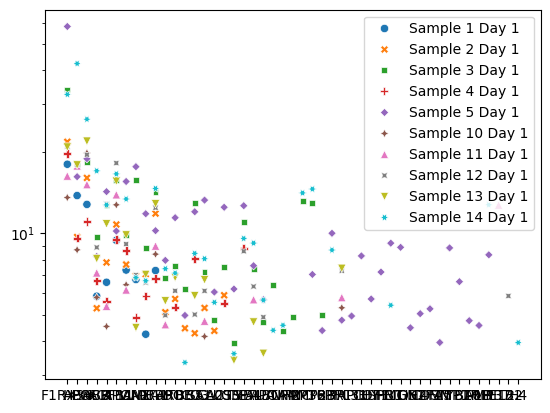

In [ ]:
import seaborn as sns
sns.scatterplot(results_df)
import matplotlib.pyplot as plt
plt.yscale("log")

0      (0.4520000000000001, 0.9, 0.09999999999999998)
1      (0.4520000000000001, 0.9, 0.09999999999999998)
2      (0.4520000000000001, 0.9, 0.09999999999999998)
3      (0.4520000000000001, 0.9, 0.09999999999999998)
4      (0.4520000000000001, 0.9, 0.09999999999999998)
                            ...                      
100    (0.4520000000000001, 0.9, 0.09999999999999998)
101    (0.5479999999999997, 0.09999999999999998, 0.9)
102    (0.5479999999999997, 0.09999999999999998, 0.9)
103    (0.5479999999999997, 0.09999999999999998, 0.9)
104    (0.5479999999999997, 0.09999999999999998, 0.9)
Name: group, Length: 105, dtype: object


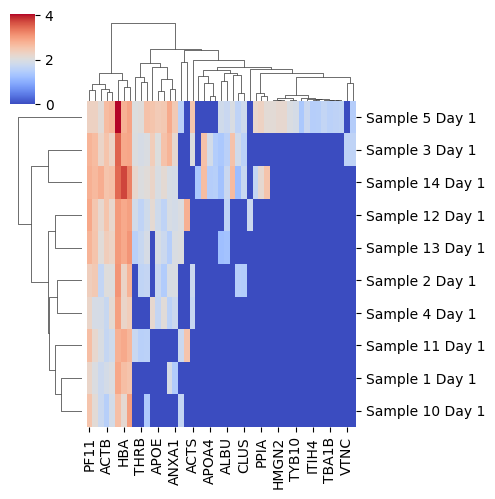

In [ ]:
import seaborn as sns
import numpy as np

labels = design["group"]
lut = dict(zip(set(labels), sns.hls_palette(len(set(labels)), l=0.5, s=0.8)))
row_colors = design["group"].map(lut)
print(row_colors)

sns.clustermap(results_df.apply(np.log).replace(np.nan, 0).T, cmap="coolwarm" , figsize=(5,5))